In [123]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
% matplotlib inline
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [57]:
e = st.norm()

In [58]:
def area_11(mu, delta):
    return (1-e.cdf(-mu-delta))**2

def area_00(mu,delta):
    return (e.cdf(-mu))**2

def corr_term_11(mu, delta):
    return ((mu/delta)*(e.cdf(-mu-delta)-e.cdf(-mu)) + (e.pdf(-mu)-e.pdf(-mu-delta))/delta)**2

def corr_term_00(mu, delta):
    return (((mu+delta)/delta)*(e.cdf(-mu-delta)-e.cdf(-mu)) + (e.pdf(-mu)-e.pdf(-mu-delta))/delta)**2

def correct_ratio_11(mu,delta):
    return area_11(mu,delta)/(area_11(mu,delta)+corr_term_11(mu, delta))

def  correct_ratio_00(mu,delta):
    return area_00(mu,delta)/(area_00(mu,delta)+corr_term_00(mu, delta))

In [151]:
mus = np.linspace(0,6,200)
deltas = np.linspace(-6,0,200)
X1, X2 = np.meshgrid(mus, deltas)
z1 = np.array([correct_ratio_00(mu, delta) for mu in mus for delta in deltas]).reshape(X1.shape)
z2 = np.array([correct_ratio_11(mu, delta) for mu in mus for delta in deltas]).reshape(X1.shape)

/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in double_scalars
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in double_scalars
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in double_scalars
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in double_scalars


/Users/susu/anaconda/lib/python3.5/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


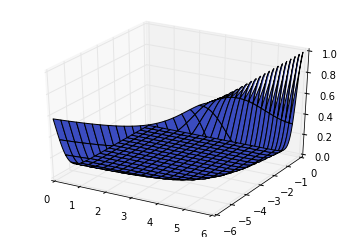

In [152]:
# correct_ratio_00
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X1, X2, z1, cmap=cm.coolwarm)
plt.show()

/Users/susu/anaconda/lib/python3.5/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


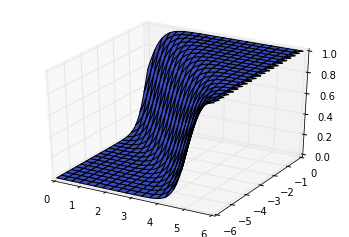

In [153]:
# correct_ratio_11
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X1, X2, z2, cmap=cm.coolwarm)
plt.show()

# sample data

In [154]:
# mixed strategyで結果を出すデータの生成
true_mu = 0.5
true_delta = -1
market_size = 10000

data = e.rvs(size = (market_size,2))
a = st.uniform()

In [155]:
def mne(x, mu,delta,random, a):
    prob_x = 1 + (mu + x[1])/delta
    prob_y = 1 + (mu+x[0])/delta
    probs = np.cumsum([prob_x*prob_y, (1-prob_x)*prob_y, prob_x*(1-prob_y), (1-prob_x)*(1-prob_y)])
    prob = a.rvs(1, random_state = random)
    ind = np.searchsorted(probs, prob)
    if ind == 0:
        return [0,0,0]
    elif ind == 1:
        return [1,0,2]
    elif ind == 2:
        return [0,1,1]
    else:
        return [1,1,3]

def nash(x, true_mu, true_delta, random, a):
    if x[0] < -true_mu:
        if x[1] < -true_mu:
            return [0,0,0]
        else :
            return [0,1,1]
    elif -true_mu < x[0] < -true_mu -true_delta:
        if x[1] < -true_mu:
            return [1,0,2]
        elif -true_mu < x[1] < -true_mu -true_delta:
            return mne(x, true_mu,true_delta, random, a)
        else:
            return [0,1,1]
    else:
        if x[1] < -true_mu -true_delta:
            return [1,0,2]
        else:
            return [1,1,3]

In [156]:
data2 = np.ones((market_size, 3))
for i in range(0,market_size):
    data2[i,:] = nash(data[i,:],true_mu, true_delta, i, a)

In [157]:
df = pd.DataFrame({"eps1" : data[:,0], "eps2" : data[:, 1], "ent1" : data2[:, 0], "ent2" : data2[:, 1], "equi" : data2[:, 2]})

## MLE

In [193]:
# MLE
def one(mu,delta):
    return e.pdf(mu+delta)**2 - e.cdf(mu+delta)*(mu+delta)*e.pdf(mu+delta)
    
def two(mu, delta):
    return (e.cdf(mu+delta)*e.pdf(mu+delta))**2

def three(mu,delta):
    return e.cdf(mu+delta)*e.pdf(mu+delta) - e.cdf(-mu)*e.pdf(mu)

def four(mu, delta):
    return e.cdf(mu+delta)*e.pdf(mu+delta)

def five(mu,delta):
    return e.pdf(mu)**2 - e.cdf(-mu)*e.pdf(mu)

def g_1(mu,delta,m11,m00,m1):
    result = 2*m11*(four(mu,delta))/area_11(mu,delta) -2*m00*(e.cdf(-mu)*e.pdf(mu))/area_00(mu,delta) - 2*m1*(three(mu,delta))/(1-area_00(mu,delta) -area_11(mu,delta))
    return result/market_size

def g_2(mu,delta,m11,m00,m1):
    result = 2*m11*(four(mu,delta))/area_11(mu,delta) -2*m1*(four(mu,delta))/(1-area_00(mu,delta) -area_11(mu,delta))
    return result/market_size

def g_11(mu,delta,m11,m00,m1):
    result =  2*m11*(one(mu,delta)*area_11(mu,delta) - 2*two(mu,delta))/((area_11(mu,delta))**2)
    -2*m00*(-five(mu,delta)*area_00(mu,delta) + 2*two(mu,delta))/((area_00(mu,delta))**2)
    -2*m1*(one(mu,delta)+five(mu,delta)*(1-area_00(mu,delta) - area_11(mu,delta)) + 2*three(mu,delta)**2)/((1 - area_00(mu,delta) - area_11(mu,delta))**2)
    return result/market_size

def g_12(mu,delta,m11,m00,m1):
    result = 2*m11*(one(mu,delta)-2*two(mu,delta))/((area_11(mu,delta))**2)
    -2*m1*(one(mu,delta)*(1-area_00(mu,delta)-area_11(mu,delta)) + 2*three(mu,delta)*four(mu,delta))/((1-area_00(mu,delta) -area_11(mu,delta))**2)
    return result/market_size

def g_22(mu,delta,m11,m00,m1):
    result = 2*m11*(one(mu,delta)*area_11(mu,delta)-2*two(mu,delta))/((area_11(mu,delta))**2)
    -2*m1*(one(mu,delta)*(1-area_00(mu,delta) -area_11(mu,delta)) + 2*two(mu,delta))/((1-area_00(mu,delta) -area_11(mu,delta))**2)
    return result/market_size

def hess(mu,delta,m11,m00,m1):
    hessian = np.ones((2,2))
    hessian[0,0] = g_11(mu,delta,m11,m00,m1)
    hessian[0,1] = g_12(mu,delta,m11,m00,m1)
    hessian[1,0] = g_12(mu,delta,m11,m00,m1)
    hessian[1,1] = g_22(mu,delta,m11,m00,m1)
    return hessian

def grad(mu,delta,m11,m00,m1):
    gradient = np.ones((2,1))
    gradient[0,0] = g_1(mu,delta,m11,m00,m1)
    gradient[1,0] = g_2(mu,delta,m11,m00,m1)
    return gradient

def NR(theta, m11,m00,m1,maxit, tol):
    for i in range(0,maxit):
        del_theta = np.linalg.inv(hess(theta[0,0],theta[1,0],m11,m00,m1)).dot(grad(theta[0,0],theta[1,0],m11,m00,m1))
        theta = theta - del_theta
        if np.linalg.norm(del_theta) < tol:
            break
    return theta

def main(theta,m11,m00,m1,maxit,tol):
    for j in range(0,maxit):
        ratio00 = correct_ratio_00(theta[0,0], theta[1,0])
        ratio11 = correct_ratio_11(theta[0,0], theta[1,0])
        newm00 = m00 * ratio00
        newm11 = m11 * ratio11
        newm1 = market_size - newm11 - newm00
        newtheta = NR(theta,newm11,newm00,newm1,maxit,tol)
        if np.linalg.norm(newtheta - theta) < tol:
            break
        theta = newtheta
    return newtheta

def main2(theta,m11,m00,m1,maxit,tol):
    for i in range(0,maxit):
        del_theta = np.linalg.inv(hess(theta[0,0],theta[1,0],m11,m00,m1)).dot(grad(theta[0,0],theta[1,0],m11,m00,m1))
        theta = theta - del_theta
        ratio00 = correct_ratio_00(theta[0,0], theta[1,0])
        ratio11 = correct_ratio_11(theta[0,0], theta[1,0])
        newm00 = m00 * ratio00
        newm11 = m11 * ratio11
        newm1 = market_size - newm11 - newm00
        del_theta = np.linalg.inv(hess(theta[0,0],theta[1,0],newm11,newm00,newm1)).dot(grad(theta[0,0],theta[1,0],newm11,newm00,newm1))
        theta = theta - del_theta
        if np.linalg.norm(del_theta) < tol:
            break
    return theta

## main roop

true_mu = 1
true_delta = -0.5

In [227]:
true_mu = 0.5
true_delta = -1
maxit = 1000
tol = 1/maxit
# 真の値で収束しないしなんかおかしいな
initial = np.array([[0.5],[-1]])
m00 = sum([True for i in df["equi"] if i == 0.0])
m11 = sum([True for i in df["equi"] if i == 3.0])
m1 = market_size - m00 - m11

In [228]:
NR(initial,m11,m00,m1,maxit,tol)

array([[-0.0790689 ],
       [-1.59999543]])

In [229]:
main(initial,m11,m00,m1,maxit,tol)

array([[-0.01756961],
       [-3.0569321 ]])

In [230]:
main2(initial,m11,m00,m1,maxit,tol)

array([[ 0.04172162],
       [-3.13027975]])